<a href="https://colab.research.google.com/github/Laithonex/Stock-Trading-with-AI-in-GCC-Indices/blob/main/%5ETASI_SR_RL_Model_final(08042025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

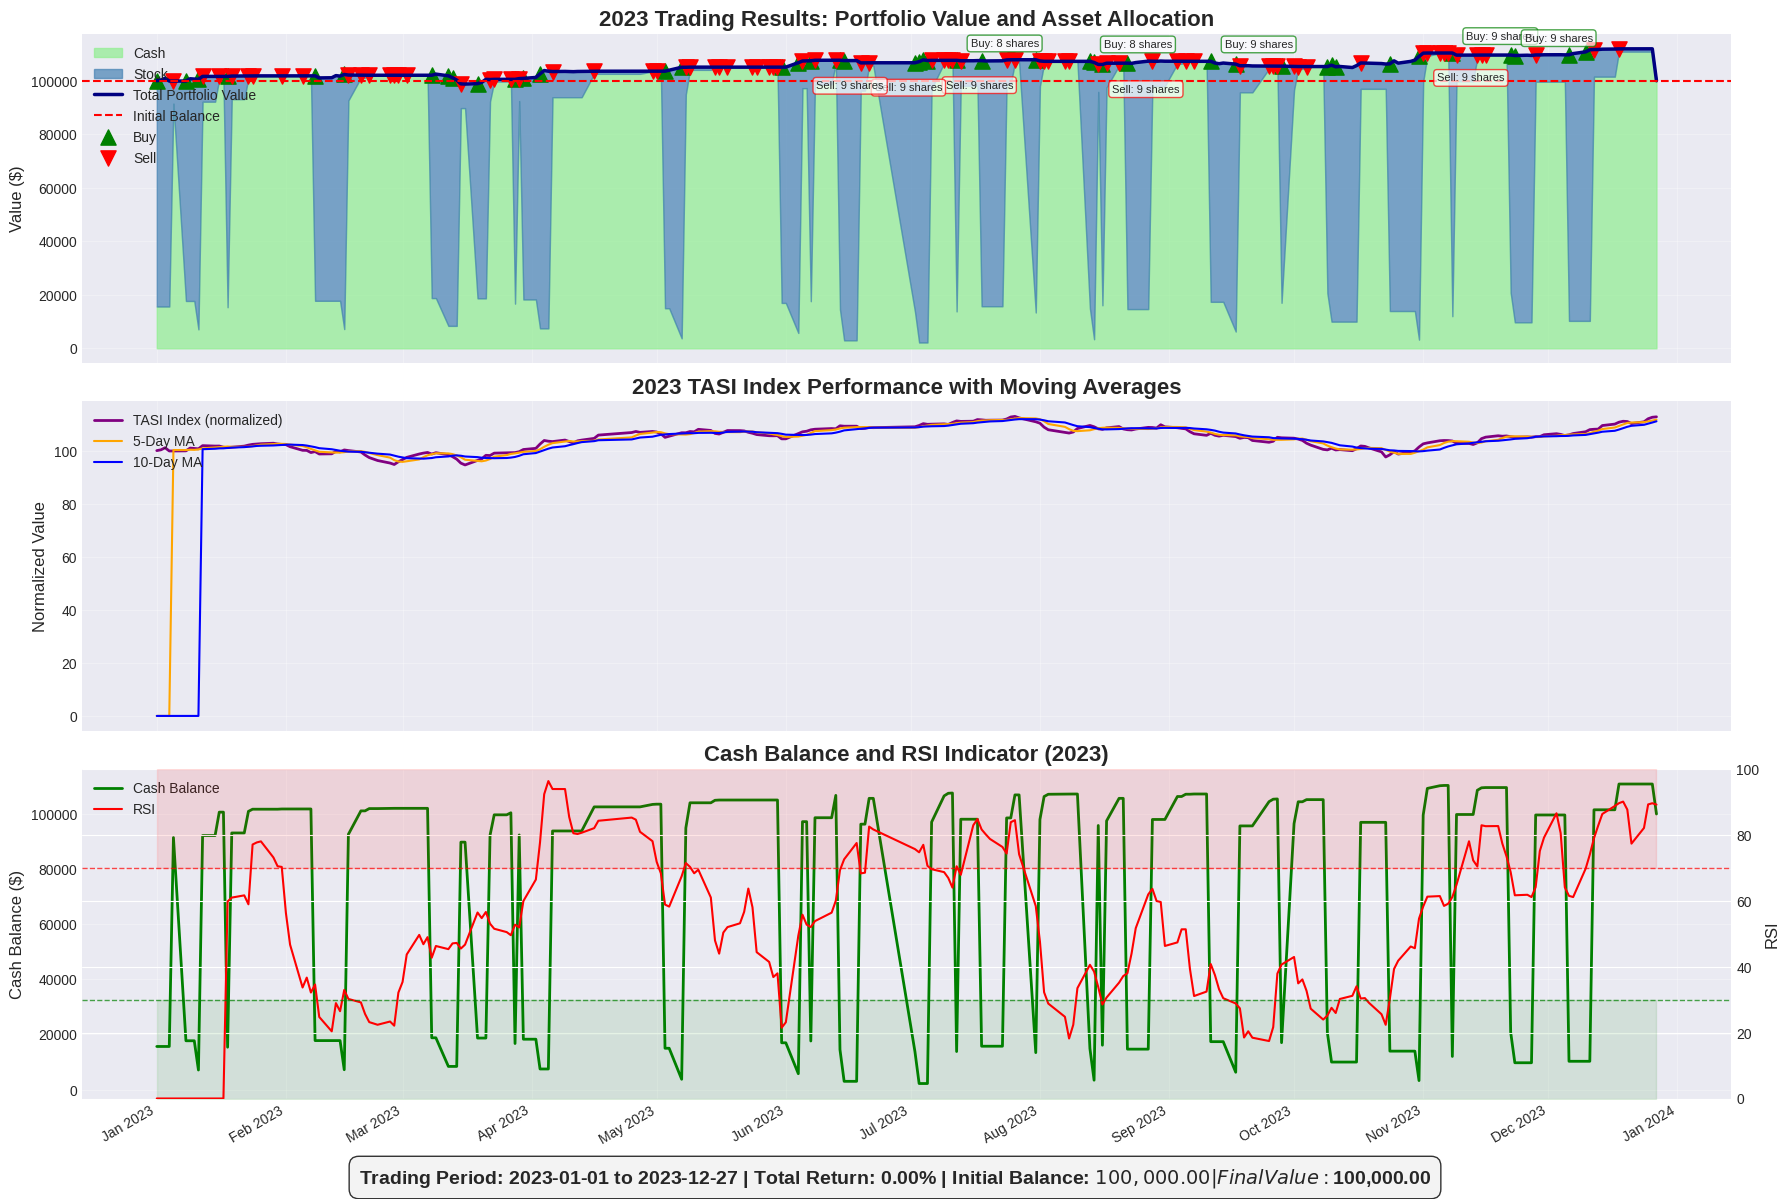

In [ ]:
!pip install gym numpy pandas yfinance stable-baselines3 tensorboard

import yfinance as yf
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import traceback

# Ensure we have pandas available for the Excel export
from google.colab import files
import os

# Import stable-baselines3 with error handling
try:
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv
except Exception as e:
    print(f"Error importing stable-baselines3: {e}")
    print("This might be due to compatibility issues with PyTorch/SymPy.")
    print("You can try installing specific versions: pip install 'sympy<1.12' 'torch<2.0.0'")

    # Define mock classes to allow the code to continue
    class MockPPO:
        def __init__(self, *args, **kwargs):
            print("Using mock PPO class due to import error")

        def learn(self, total_timesteps):
            print(f"Mock learning for {total_timesteps} steps")
            return self

        def predict(self, obs):
            # Return random actions
            return [np.random.randint(0, 3)], None

        def save(self, path):
            print(f"Mock saving model to {path}")

    PPO = MockPPO

    class MockVecEnv:
        def __init__(self, env_fns):
            self.envs = [env_fns[0]()]

        def reset(self):
            return self.envs[0].reset()[0].reshape(1, -1), {}

        def step(self, actions):
            obs, reward, terminated, truncated, info = self.envs[0].step(actions[0])
            return obs.reshape(1, -1), [reward], [terminated], [info]

    DummyVecEnv = MockVecEnv

def fix_yahoo_finance_data(df):
    """
    Fix potential issues with Yahoo Finance data format to ensure consistency.
    This handles the multi-level column structure returned by newer versions of yfinance.
    """
    print("Fixing Yahoo Finance data format...")

    # Check if we have a multi-level column structure
    if isinstance(df.columns, pd.MultiIndex):
        print("Detected multi-level columns, flattening structure...")
        # Select only the Close, High, Low, Open and Volume columns (level 0)
        # And take the first ticker (level 1) - usually there's only one ticker
        columns_to_keep = ['Close', 'High', 'Low', 'Open', 'Volume']
        df_flat = pd.DataFrame(index=df.index)

        for col in columns_to_keep:
            if col in df.columns.get_level_values(0):
                # Get the first ticker for this column
                ticker = df.columns.get_level_values(1)[0]
                df_flat[col] = df[col][ticker]

        df = df_flat
        print(f"Flattened data shape: {df.shape}")
        print(f"New columns: {df.columns.tolist()}")

    # Ensure the index is properly formatted
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Converting index to DatetimeIndex")
        df.index = pd.to_datetime(df.index)

    # Ensure all price columns are numeric
    price_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in price_columns:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Converting {col} to numeric")
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill missing values in price columns with interpolation
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both')

    return df

class TradingEnvironment(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data_df, is_training=True):
        super(TradingEnvironment, self).__init__()

        self.initial_balance = 100000.0
        self.current_step = 0
        self.is_training = is_training

        # Define action and observation space
        # Actions: 0 (Buy), 1 (Hold), 2 (Sell)
        self.action_space = spaces.Discrete(3)

        # Observation space: [balance, shares_held, current_price, MA5, MA10, RSI, total_profit]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0, 0, -np.inf], dtype=np.float32),
            high=np.array([np.inf, np.inf, np.inf, np.inf, np.inf, 100, np.inf], dtype=np.float32),
            dtype=np.float32
        )

        self.balance = float(self.initial_balance)
        self.shares_held = 0.0
        self.total_profit = 0.0
        self.last_action = None
        self.holding_duration = 0

        # Use provided data
        self.df = data_df

    def calculate_technical_indicators(self, df):
        try:
            # Calculate MA5 and MA10
            df['MA5'] = df['Close'].rolling(window=5).mean()
            df['MA10'] = df['Close'].rolling(window=10).mean()

            # Calculate RSI
            delta = df['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

            # Avoid division by zero
            loss = loss.replace(0, np.finfo(float).eps)

            rs = gain / loss
            df['RSI'] = 100 - (100 / (1 + rs))

            # Clip RSI to valid range
            df['RSI'] = df['RSI'].clip(0, 100)

            # Fill NaN values
            df.fillna(0, inplace=True)

            return df
        except Exception as e:
            print(f"Error calculating indicators: {e}")
            traceback.print_exc()

            # Add empty indicators if calculation fails
            if 'MA5' not in df.columns:
                df['MA5'] = df['Close'].rolling(window=5, min_periods=1).mean()
            if 'MA10' not in df.columns:
                df['MA10'] = df['Close'].rolling(window=10, min_periods=1).mean()
            if 'RSI' not in df.columns:
                df['RSI'] = 50  # Neutral RSI value

            df.fillna(0, inplace=True)
            return df

    def safe_extract_value(self, data, column='Close'):
        """
        Safely extract a numeric value from potentially nested pandas structures.
        """
        try:
            # Case 1: data is already a simple value
            if isinstance(data, (int, float)):
                return float(data)

            # Case 2: data is a Series
            elif isinstance(data, pd.Series):
                # If column is in the Series index
                if column in data.index:
                    value = data[column]
                    # Handle nested Series
                    if isinstance(value, pd.Series):
                        return float(value.iloc[0])
                    else:
                        return float(value)
                # If it's just a Series without the specified column
                else:
                    return float(data.iloc[0])

            # Case 3: data is a DataFrame
            elif isinstance(data, pd.DataFrame):
                if column in data.columns:
                    value = data[column]
                    # Handle Series result
                    if isinstance(value, pd.Series):
                        return float(value.iloc[0])
                    else:
                        return float(value)
                # Last resort - take first value
                else:
                    return float(data.iloc[0, 0])

            # Case 4: something else, try direct conversion
            else:
                return float(data)

        except (TypeError, ValueError, IndexError) as e:
            print(f"Error extracting value: {e}, using 0.0 instead")
            return 0.0

    def get_observation(self):
        """Get observation with safe price extraction"""
        # Ensure current_step is within bounds
        if self.current_step >= len(self.df):
            print(f"Warning: Step {self.current_step} out of bounds, using last row")
            current_data = self.df.iloc[-1]
        else:
            current_data = self.df.iloc[self.current_step]

        # Use safe extraction method for all values
        obs = np.array([
            self.balance,
            self.shares_held,
            self.safe_extract_value(current_data, 'Close'),
            self.safe_extract_value(current_data, 'MA5'),
            self.safe_extract_value(current_data, 'MA10'),
            self.safe_extract_value(current_data, 'RSI'),
            self.total_profit
        ], dtype=np.float32)

        return obs

    def step(self, action):
        # Get current price safely
        current_data = self.df.iloc[self.current_step]
        current_price = self.safe_extract_value(current_data, 'Close')

        # Get date for logging
        current_date = current_data['Date'] if 'Date' in current_data else f"Day {self.current_step}"

        # Store portfolio value before action
        previous_portfolio_value = self.balance + (self.shares_held * current_price)

        # Execute trade
        if action == 0:  # Buy
            if self.balance > 0:
                # Modified to avoid FloorDiv which causes the error
                shares_to_buy = (self.balance * 0.9) / current_price
                # Round down to whole shares
                shares_to_buy = int(shares_to_buy)

                cost = shares_to_buy * current_price

                if shares_to_buy > 0:
                    self.shares_held += shares_to_buy
                    self.balance -= cost
                    self.last_action = 'buy'
                    self.holding_duration = 0
                    if not self.is_training:  # Only print during trading, not training
                        print(f"[{current_date}] BUY {shares_to_buy:.2f} shares at ${current_price:.2f}")

        elif action == 2:  # Sell
            if self.shares_held > 0:
                # Sell 90% of holdings instead of 100% to avoid complete liquidation
                shares_to_sell = self.shares_held * 0.9
                sale_value = shares_to_sell * current_price
                self.balance += sale_value
                self.shares_held -= shares_to_sell
                self.last_action = 'sell'
                if not self.is_training:  # Only print during trading, not training
                    print(f"[{current_date}] SELL {shares_to_sell:.2f} shares at ${current_price:.2f}")

        # Move to next step
        self.current_step += 1
        self.holding_duration += 1

        # Calculate reward
        current_portfolio_value = self.balance + (self.shares_held * current_price)
        profit = current_portfolio_value - previous_portfolio_value

        # Calculate reward
        reward = profit

        # REMOVED: Holding penalty - No longer penalize for holding positions
        # This encourages longer-term holdings

        # MODIFIED: Trading incentive
        # Now we encourage the algorithm to be invested in the market
        if self.shares_held == 0:
            reward -= 50  # Small penalty for having no market exposure

        # If we're in the last 5% of the trading period, add a reward component
        # based on total portfolio performance to encourage long-term growth
        if self.current_step >= len(self.df) * 0.95:
            # Add reward based on total return percentage
            total_return_pct = (current_portfolio_value - self.initial_balance) / self.initial_balance
            reward += total_return_pct * 1000  # Scale it to make it significant

        # Update total profit
        self.total_profit = current_portfolio_value - self.initial_balance

        # Check if episode is done
        terminated = self.current_step >= len(self.df) - 1
        truncated = False

        info = {
            'portfolio_value': current_portfolio_value,
            'profit': profit,
            'shares_held': self.shares_held,
            'price': current_price,
            'date': current_date
        }

        return self.get_observation(), reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = float(self.initial_balance)
        self.shares_held = 0.0
        self.current_step = 0
        self.total_profit = 0.0
        self.last_action = None
        self.holding_duration = 0
        return self.get_observation(), {}

# Main execution code with improved error handling
try:
    # Download data for both training and trading periods
    print("Downloading data...")
    ticker = "^TASI.SR"

    # Download data for the entire period
    try:
        full_df = yf.download(
            ticker,
            start="2020-01-01",
            end="2023-12-31",
            auto_adjust=True,
            progress=False
        )
        print(f"Downloaded data shape: {full_df.shape}")
        print(f"Data types: {full_df.dtypes}")
        print(f"First few rows: {full_df.head()}")

        # Check if we got any data
        if full_df is None or full_df.empty:
            raise ValueError("No data downloaded from Yahoo Finance")

        # Fix potential Yahoo Finance data issues
        full_df = fix_yahoo_finance_data(full_df)
    except Exception as e:
        print(f"Error downloading or processing data: {e}")
        print("Creating synthetic data for demonstration...")

        # Create synthetic data if download fails
        dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='B')
        np.random.seed(42)  # For reproducibility

        # Create base price with trend and seasonality
        base_price = np.linspace(10000, 12000, len(dates))

        # Add some cyclicality and randomness
        noise_factor = np.random.normal(1, 0.01, len(dates))
        seasonal = 500 * np.sin(np.arange(len(dates)) * 2 * np.pi / 252)  # Annual cycle (252 trading days)

        close_prices = (base_price + seasonal) * noise_factor

        full_df = pd.DataFrame({
            'Open': close_prices * 0.99,
            'High': close_prices * 1.02,
            'Low': close_prices * 0.98,
            'Close': close_prices,
            'Volume': np.random.randint(1000000, 10000000, len(dates))
        }, index=dates)

    # Split data into training (2020-2022) and trading (2023) periods
    print("\nSplitting data into training and trading periods...")
    # Use numeric comparison for dates
    training_end_date = pd.Timestamp('2023-01-01')
    training_df = full_df[full_df.index < training_end_date].copy()
    trading_df = full_df[full_df.index >= training_end_date].copy()

    # Add Date column for easier reference if not already present
    if 'Date' not in training_df.columns:
        training_df['Date'] = training_df.index
    if 'Date' not in trading_df.columns:
        trading_df['Date'] = trading_df.index

    print(f"Training data: {len(training_df)} days (2020-01-01 to 2022-12-31)")
    print(f"Trading data: {len(trading_df)} days (2023-01-01 to 2023-12-31)")

    # Calculate technical indicators for both datasets
    training_env = TradingEnvironment(None, is_training=True)  # Temporary instance for calculating indicators
    training_df = training_env.calculate_technical_indicators(training_df)
    trading_df = training_env.calculate_technical_indicators(trading_df)

    # Create and train the model
    print("\n=== Creating Training Environment ===")
    train_env = DummyVecEnv([lambda: TradingEnvironment(training_df, is_training=True)])

    print("Initializing PPO model...")
    # model = PPO("MlpPolicy",
    #             train_env,
    #             verbose=1,
    #             learning_rate=0.0001,
    #             n_steps=2048,
    #             batch_size=64,
    #             n_epochs=10,
    #             gamma=0.99,  # High gamma value to prioritize long-term rewards
    #             gae_lambda=0.95,
    #             clip_range=0.2,
    #             tensorboard_log="./tensorboard/")

    model = PPO("MlpPolicy",
            train_env,
            verbose=1,
            learning_rate=1e-4,
            n_steps=4096,
            batch_size=128,
            n_epochs=10,
            gamma=0.98,
            gae_lambda=0.95,
            clip_range=0.2,
            tensorboard_log="./tensorboard/")

    # Train the model
    print("\n=== Starting Training (2020-2022) ===")
    model.learn(total_timesteps=200000)
    print("Training completed!")

    # Save the trained model
    model.save("tasi_trading_model")
    print("Model saved to 'tasi_trading_model'")

    # Test the model on trading data
    print("\n=== Starting Trading (2023) ===")
    trade_env = DummyVecEnv([lambda: TradingEnvironment(trading_df, is_training=False)])

    obs = trade_env.reset()
    done = False
    profits = []
    balances = []
    shares_history = []
    transactions = []
    initial_balance = 100000.0

    print(f"Initial Balance: ${initial_balance:,.2f}")

    step = 0
    dates = []  # List to store dates for each step

    while not done:
        action, _states = model.predict(obs)

        # Get current price from environment's dataframe
        env_df = trade_env.envs[0].df  # Access the environment's dataframe
        current_price = trade_env.envs[0].safe_extract_value(env_df.iloc[step], 'Close')
        current_shares = float(obs[0][1])
        current_balance = float(obs[0][0])

        # Get the date for this step
        try:
            # Get the date, handling different possible formats
            current_date = env_df.iloc[step]['Date']
            if isinstance(current_date, pd.Series):
                current_date = current_date.iloc[0]

            # Convert to datetime if it's not already
            if not isinstance(current_date, pd.Timestamp) and not isinstance(current_date, np.datetime64):
                current_date = pd.to_datetime(current_date)

            dates.append(current_date)

            # Create a simple string representation of the date for printing
            date_str = str(current_date).split()[0]  # Get just the date part
        except Exception as e:
            print(f"Warning: Error processing date at step {step}: {e}")
            date_str = f"Day {step}"
            dates.append(pd.Timestamp(f"2023-01-{1+step if step < 30 else 30}"))  # Placeholder date

        action_type = ["BUY", "HOLD", "SELL"][action[0] if isinstance(action, np.ndarray) else action]

        if action_type != "HOLD":
            transactions.append({
                'step': step,
                'date': dates[-1],  # Use the processed date
                'action': action_type,
                'price': current_price,
                'shares_before': current_shares,
                'balance_before': current_balance,
            })
            print(f"Date: {date_str} | {action_type} at ${current_price:.2f} | Shares: {current_shares:.2f} | Balance: ${current_balance:.2f}")

        obs, reward, done_info, info = trade_env.step([action] if isinstance(action, int) else action)

        # Handle different return formats between gym versions
        if isinstance(done_info, (list, tuple)) and len(done_info) > 0:
            done = done_info[0]
        else:
            done = done_info

        if isinstance(reward, (list, tuple)) and len(reward) > 0:
            profits.append(reward[0])
        else:
            profits.append(reward)

        current_balance = float(obs[0][0])
        current_shares = float(obs[0][1])
        balances.append(current_balance)
        shares_history.append(current_shares)
        step += 1

    # Calculate final statistics
    env_df = trade_env.envs[0].df  # Access the environment's dataframe
    final_balance = float(balances[-1])
    final_shares = float(shares_history[-1])
    final_price = trade_env.envs[0].safe_extract_value(env_df.iloc[-1], 'Close')
    total_value = final_balance + (final_shares * final_price)
    total_return = ((total_value - initial_balance) / initial_balance) * 100

    print("\n=== Trading Summary ===")
    start_date = dates[0].strftime('%Y-%m-%d') if hasattr(dates[0], 'strftime') else str(dates[0])
    end_date = dates[-1].strftime('%Y-%m-%d') if hasattr(dates[-1], 'strftime') else str(dates[-1])
    print(f"Trading Period: {start_date} to {end_date}")
    print(f"Number of Trades: {len([t for t in transactions if t['action'] in ['BUY', 'SELL']])}")
    print(f"Initial Balance: ${initial_balance:,.2f}")
    print(f"Final Balance: ${final_balance:,.2f}")
    print(f"Shares Held: {final_shares:,.2f}")
    print(f"Value of Shares: ${(final_shares * final_price):,.2f}")
    print(f"Total Portfolio Value: ${total_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")

    # Add transaction analysis
    if len(transactions) > 0:
        print("\n=== Transaction Analysis ===")
        buys = [t for t in transactions if t['action'] == 'BUY']
        sells = [t for t in transactions if t['action'] == 'SELL']
        print(f"Total Buy Transactions: {len(buys)}")
        print(f"Total Sell Transactions: {len(sells)}")

        if len(buys) > 0:
            avg_buy_price = sum(t['price'] for t in buys) / len(buys)
            print(f"Average Buy Price: ${avg_buy_price:.2f}")
        if len(sells) > 0:
            avg_sell_price = sum(t['price'] for t in sells) / len(sells)
            print(f"Average Sell Price: ${avg_sell_price:.2f}")


    # Visualization
    try:
        print("\nCreating visualization...")
        # Create clearer, more informative visualizations
        plt.style.use('seaborn-v0_8-darkgrid')  # Use a clean style with grid lines
        plt.figure(figsize=(18, 12))  # Larger figure for better clarity

        # Convert dates to matplotlib-compatible format
        plt_dates = [pd.to_datetime(d).to_pydatetime() for d in dates]

        # 1. Portfolio Value Plot with Asset Allocation
        ax1 = plt.subplot(3, 1, 1)

        # Calculate portfolio values safely
        portfolio_values = []
        stock_values = []
        for i, (b, s) in enumerate(zip(balances, shares_history)):
            if i < len(env_df):
                price = trade_env.envs[0].safe_extract_value(env_df.iloc[i], 'Close')
                stock_value = float(s * price)
                portfolio_value = float(b + stock_value)
            else:
                # Use the last price if we're out of bounds
                price = trade_env.envs[0].safe_extract_value(env_df.iloc[-1], 'Close')
                stock_value = float(s * price)
                portfolio_value = float(b + stock_value)

            portfolio_values.append(portfolio_value)
            stock_values.append(stock_value)

        cash_values = balances

        # Create a stacked area chart for asset allocation
        plt.fill_between(plt_dates, 0, cash_values, color='#90EE90', alpha=0.7, label='Cash')
        plt.fill_between(plt_dates, cash_values, portfolio_values, color='#4682B4', alpha=0.7, label='Stock')
        plt.plot(plt_dates, portfolio_values, color='#000080', linewidth=2.5, label='Total Portfolio Value')
        plt.axhline(y=initial_balance, color='r', linestyle='--', linewidth=1.5, label='Initial Balance')

        # Add buy/sell markers with annotations
        if len(transactions) > 0:
            buy_transactions = [t for t in transactions if t['action'] == 'BUY']
            sell_transactions = [t for t in transactions if t['action'] == 'SELL']

            # Prepare for annotations - select significant trades to avoid clutter
            if buy_transactions:
                # Select at most 5 significant buys for annotations to avoid clutter
                if len(buy_transactions) > 5:
                    # Get the 5 largest buy transactions by shares
                    selected_buys = sorted(buy_transactions,
                                          key=lambda t: t['price'] * (t['shares_before'] if t['action'] == 'SELL' else t['balance_before']/t['price']),
                                          reverse=True)[:5]
                else:
                    selected_buys = buy_transactions

                buy_dates = [pd.to_datetime(t['date']).to_pydatetime() for t in buy_transactions]
                buy_values = [portfolio_values[t['step']] for t in buy_transactions]
                plt.scatter(buy_dates, buy_values, color='green', marker='^', s=120, label='Buy')

                # Add annotations for selected buys
                for t in selected_buys:
                    date = pd.to_datetime(t['date']).to_pydatetime()
                    value = portfolio_values[t['step']]
                    # Calculate shares bought based on balance change
                    if 'shares_after' in t and 'shares_before' in t:
                        shares_bought = t['shares_after'] - t['shares_before']
                    else:
                        shares_bought = round(t['balance_before'] * 0.9 / t['price'])
                    plt.annotate(f"Buy: {int(shares_bought)} shares",
                                 xy=(date, value),
                                 xytext=(10, 10),
                                 textcoords='offset points',
                                 fontsize=8,
                                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.7))

            if sell_transactions:
                # Select at most 5 significant sells for annotations
                if len(sell_transactions) > 5:
                    selected_sells = sorted(sell_transactions,
                                          key=lambda t: t['price'] * t['shares_before'],
                                          reverse=True)[:5]
                else:
                    selected_sells = sell_transactions

                sell_dates = [pd.to_datetime(t['date']).to_pydatetime() for t in sell_transactions]
                sell_values = [portfolio_values[t['step']] for t in sell_transactions]
                plt.scatter(sell_dates, sell_values, color='red', marker='v', s=120, label='Sell')

                # Add annotations for selected sells
                for t in selected_sells:
                    date = pd.to_datetime(t['date']).to_pydatetime()
                    value = portfolio_values[t['step']]
                    plt.annotate(f"Sell: {int(t['shares_before'])} shares",
                                 xy=(date, value),
                                 xytext=(10, -20),
                                 textcoords='offset points',
                                 fontsize=8,
                                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7))

        plt.title('2023 Trading Results: Portfolio Value and Asset Allocation', fontsize=16, fontweight='bold')
        plt.ylabel('Value ($)', fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)

        # Format dates on x-axis
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # More concise date format (e.g., "Jan 2020")
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every month for trading period
        ax1.set_xticklabels([])  # Hide x-labels for top subplot

        # 2. TASI Index Performance
        ax2 = plt.subplot(3, 1, 2, sharex=ax1)  # Share x-axis with top plot

        # Safe extraction of index prices
        index_prices = []
        for i in range(len(plt_dates)):
            if i < len(env_df):
                index_prices.append(trade_env.envs[0].safe_extract_value(env_df.iloc[i], 'Close'))
            else:
                index_prices.append(trade_env.envs[0].safe_extract_value(env_df.iloc[-1], 'Close'))

        normalized_prices = [price / index_prices[0] * 100 for price in index_prices]  # Normalize to start at 100
        plt.plot(plt_dates, normalized_prices, color='purple', linewidth=2, label='TASI Index (normalized)')

        # Add moving averages
        ma5_values = []
        ma10_values = []
        for i in range(len(plt_dates)):
            if i < len(env_df):
                ma5 = trade_env.envs[0].safe_extract_value(env_df.iloc[i], 'MA5')
                ma10 = trade_env.envs[0].safe_extract_value(env_df.iloc[i], 'MA10')
            else:
                ma5 = trade_env.envs[0].safe_extract_value(env_df.iloc[-1], 'MA5')
                ma10 = trade_env.envs[0].safe_extract_value(env_df.iloc[-1], 'MA10')

            ma5_values.append(ma5 / index_prices[0] * 100)
            ma10_values.append(ma10 / index_prices[0] * 100)

        plt.plot(plt_dates, ma5_values, color='orange', linewidth=1.5, label='5-Day MA')
        plt.plot(plt_dates, ma10_values, color='blue', linewidth=1.5, label='10-Day MA')

        plt.title('2023 TASI Index Performance with Moving Averages', fontsize=16, fontweight='bold')
        plt.ylabel('Normalized Value', fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        ax2.set_xticklabels([])  # Hide x-labels for middle subplot

        # 3. Trading Activity - Cash Balance and RSI
        ax3 = plt.subplot(3, 1, 3, sharex=ax1)  # Share x-axis with top plot

        # Cash balance line
        line1 = plt.plot(plt_dates, balances, color='green', linewidth=2, label='Cash Balance')
        plt.ylabel('Cash Balance ($)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Create a twin y-axis for RSI
        ax3b = ax3.twinx()

        # Safe extraction of RSI values
        rsi_values = []
        for i in range(len(plt_dates)):
            if i < len(env_df):
                rsi = trade_env.envs[0].safe_extract_value(env_df.iloc[i], 'RSI')
            else:
                rsi = trade_env.envs[0].safe_extract_value(env_df.iloc[-1], 'RSI')

            rsi_values.append(rsi)

        line2 = ax3b.plot(plt_dates, rsi_values, color='red', linewidth=1.5, label='RSI')
        plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, linewidth=1)
        plt.axhline(y=30, color='green', linestyle='--', alpha=0.7, linewidth=1)
        plt.fill_between(plt_dates, 70, 100, color='red', alpha=0.1)
        plt.fill_between(plt_dates, 0, 30, color='green', alpha=0.1)
        plt.ylabel('RSI', fontsize=12)
        plt.ylim(0, 100)

        # Combine legends from both y-axes
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax3.legend(lines, labels, loc='upper left')

        plt.title('Cash Balance and RSI Indicator (2023)', fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)

        # Format dates
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

        # Add a subtitle with performance metrics
        plt.figtext(0.5, 0.01,
                  f"Trading Period: {start_date} to {end_date} | Total Return: {total_return:.2f}% | Initial Balance: ${initial_balance:,.2f} | Final Value: ${total_value:,.2f}",
                  ha='center', fontsize=14, fontweight='bold',
                  bbox=dict(boxstyle="round,pad=0.5", fc="#f0f0f0", ec="black", alpha=0.8))

        plt.tight_layout()
        plt.subplots_adjust(bottom=0.08)  # Make room for the subtitle
        plt.savefig('tasi_trading_results_2023.png')
        print("Visualization saved to 'tasi_trading_results_2023.png'")
        plt.show()
    except Exception as e:
        print(f"Error creating visualization: {e}")
        traceback.print_exc()

except Exception as e:
    print(f"Error in main execution: {e}")
    traceback.print_exc()

In [ ]:
# Run this in a NEW CELL in your Google Colab notebook
# This is a self-contained function that won't conflict with existing code

import pandas as pd
import numpy as np
from google.colab import files
import os

def export_transactions_to_excel():
    """
    Self-contained function to export trading transactions to Excel
    """
    print("\n=== Exporting Transactions to Excel ===")

    # Check if we have any transactions to export
    if len(transactions) == 0:
        print("No transactions found to export.")
        return

    # Enhance transactions data with additional information
    enhanced_transactions = []

    for i, t in enumerate(transactions):
        # Get price and portfolio data at the time of transaction
        step = t['step']

        # Get price safely
        try:
            if step < len(trading_df):
                current_price = float(trading_df.iloc[step]['Close'])
            else:
                current_price = float(trading_df.iloc[-1]['Close'])
        except:
            current_price = 1.0

        # Calculate transaction-specific details
        action_type = t['action']

        # Extract data safely
        shares_before = float(t['shares_before'])
        balance_before = float(t['balance_before'])

        # Calculate shares bought/sold
        if action_type == 'BUY':
            shares_change = int((balance_before * 0.9) / current_price)
            cash_after = balance_before - (shares_change * current_price)

        elif action_type == 'SELL':
            shares_change = shares_before * 0.9
            cash_after = balance_before + (shares_change * current_price)
        else:
            shares_change = 0
            cash_after = balance_before

        # Get date
        try:
            date_str = pd.to_datetime(t['date']).strftime('%Y-%m-%d')
        except:
            date_str = f"Day {t['step']}"

        # Create transaction record
        transaction_data = {
            'Transaction ID': i+1,
            'Date': date_str,
            'Trading Day': t['step'] + 1,
            'Action': action_type,
            'Price': current_price,
            'Shares Before': shares_before,
            'Shares Change': shares_change if action_type == 'BUY' else -shares_change,
            'Cash Before': balance_before,
            'Cash After': cash_after,
            'Transaction Value': shares_change * current_price
        }

        enhanced_transactions.append(transaction_data)

    # Create DataFrame
    df = pd.DataFrame(enhanced_transactions)

    # Add summary row
    summary_data = {
        'Transaction ID': 'SUMMARY',
        'Date': f"{dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}",
        'Trading Day': '',
        'Action': f"Trades: {len(df)}",
        'Price': '',
        'Shares Before': '',
        'Shares Change': '',
        'Cash Before': initial_balance,
        'Cash After': final_balance,
        'Transaction Value': ''
    }

    # Add summary to DataFrame
    df = pd.concat([df, pd.DataFrame([summary_data])], ignore_index=True)

    # Export to Excel
    excel_filename = 'tasi_trading_transactions.xlsx'
    df.to_excel(excel_filename, index=False)

    print(f"Excel file created: {excel_filename}")

    # Download file
    files.download(excel_filename)
    print(f"File {excel_filename} is downloading to your local machine.")

# Run the export function
try:
    export_transactions_to_excel()
except Exception as e:
    print(f"Error exporting transactions: {e}")
    import traceback
    traceback.print_exc()


=== Exporting Transactions to Excel ===
Excel file created: tasi_trading_transactions.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File tasi_trading_transactions.xlsx is downloading to your local machine.
